In [227]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from nltk.corpus import stopwords
import numpy as np
from urllib.request import urlopen
from urllib.error import URLError, HTTPError
import pandas as pd
import seaborn as sns 
from sklearn.cluster import KMeans
import string
import re
import burst_detection as bd
import warnings
import glob
from itertools import dropwhile
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import pickle
import os.path

In [228]:
#settings
%matplotlib inline
rcParams['figure.figsize'] = 15, 6
pd.set_option('display.max_colwidth', -1) #show full columns
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=np.inf)

In [229]:
#function to extract images stored in a df
def image_extract(x,file_name,n):
    x_sample = x.sample(n)
    img_urls = x_sample['image_url']
    for index, url in enumerate(img_urls):
        try:
            link = urlopen(url)
        except:
            print("Bad URL")
            continue
        try:
            name = "%s%s.jpg" % (file_name, (index+1))
            with open(name, "wb") as output:
                output.write(link.read())
        except IOError:
            print("Unable to create %s") % name

In [230]:
#word count function
def freq_dist(data, n_words):
    ngram_vectorizer = CountVectorizer(analyzer='word', tokenizer=word_tokenize, ngram_range=(1, 1), min_df=1)
    X = ngram_vectorizer.fit_transform(data)
    vocab = list(ngram_vectorizer.get_feature_names())
    counts = X.sum(axis=0).A1
    freq_distribution = Counter(dict(zip(vocab, counts)))
    return freq_distribution.most_common(n_words)

In [231]:
path = 'data/'
allFiles = glob.glob(path + "/*.tsv")
df = pd.concat((pd.read_csv(f, delimiter='\t') for f in allFiles))

In [233]:
df = df[~df['date'].str.contains('date')] #remove duplicate header rows
df = df[~df['ocr'].astype(str).str.contains('objecttype')] #remove rows with restricted error msg
df = df[~df['ocr'].astype(str).str.contains('file directory not found')]

In [234]:
df['date'] = df['date'].astype('datetime64[ns]')
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
df = df.sort_values(by='date')

## PreProcessing

In [235]:
stop_word = set(stopwords.words('dutch'))
regex_pat = re.compile(r'[^a-zA-Z\s]', flags=re.IGNORECASE)
df['ocr_clean'] = df['ocr'].str.replace(regex_pat, '') #only keep words
df['ocr_clean'] = df['ocr_clean'].str.findall('\w{4,}').str.join(' ') #only keep words more than 3 chars
df['ocr_clean'] = df['ocr_clean'].str.lower() #lower
df['ocr_clean'] = df['ocr_clean'].apply(lambda S:S.strip('Advertentie ')) #remove initial Advertentie
df['ocr_clean'] = df['ocr_clean'].str.strip() #remove shitespaces
df['ocr_clean'] = [' '.join(filter(None,filter(lambda word: word not in stop_word, line))) for line in df['ocr_clean'].str.lower().str.split(' ')]

In [236]:
#calculating proportion of characters relative to size of the advertisement. 
df['area'] = df['w'] * df['h']
df['string_length'] = df['ocr_clean'].str.len()
df['character_proportion'] = df['string_length'] / df ['area']
df = df[df['character_proportion'] < 10] #remove ads with lot of text (i.e. ocr errors)

In [237]:
#write pickle in increments due to size
file_path = "ads.pkl"
n_bytes = 2**31
max_bytes = 2**31 - 1
data = bytearray(n_bytes)

## write
bytes_out = pickle.dumps(df)
with open(file_path, 'wb') as f_out:
    for idx in range(0, n_bytes, max_bytes):
        f_out.write(bytes_out[idx:idx+max_bytes])

In [ ]:
## read pickle
#bytes_in = bytearray(0)
#input_size = os.path.getsize(file_path)
#with open(file_path, 'rb') as f_in:
#    for _ in range(0, input_size, max_bytes):
#        bytes_in += f_in.read(max_bytes)
#data2 = pickle.loads(bytes_in)

In [240]:
car_brands = [
    r'\bopel\b',
    r'\brenault\b',
    r'\baudi\b',
    r'\bsimca\b',
    r'\bpeugeot\b',
    r'\bbuick\b',
    r'\bvolkswagen\b',
    r'\bford\b',
    r'\bStandard\b',
    r'\bTriumph\b',
    r'\bfiat\b',
    r'\bnissan\b',
    r'\bBMW\b',
    r'\bmercedes\b',
    r'\bporsche\b',
    r'\bdaewoo\b',
    r'\btoyota\b',
    r'\balfa romeo\b',
    r'\bsubaru\b',
    r'\bhonda\b',
    r'\blexus\b',
    r'\bmazda\b',
    r'\blada\b',
    r'\bhyundai\b',
    r'\bbentley\b',
    r'\bjaguar\b',
    r'\bcadillac\b',
    r'\bchevrolet\b',
    r'\bchrysler\b',
    r'\bjeep\b',
]

In [241]:
car_df = df[df['ocr_clean'].str.contains('|'.join(car_brands))]

In [242]:
ads_image = car_df[car_df['character_proportion'] < 0.00020] #car ads with image and text

In [245]:
#clean df
ads_image = ads_image.reset_index(drop=True)
drop_cols = ['min_x', 'min_y', 'max_x', 'max_y', 'w', 'h', 'ocr', 'area']
ads_image.drop(drop_cols, axis=1, inplace=True)

In [247]:
ads_image.to_pickle('ads_image.pkl')
#ads_df = pd.read_pickle('ads_image.pkl')

In [262]:
#ads_image_sample = ads_image.sample(frac=.25)
#image_extract(ads_image_sample, 'cars')

In [248]:
ads_df['publication_year'] = ads_df['date'].apply(lambda x: x.year)
ads_df['publication_month'] = ads_df['date'].apply(lambda x: x.month)
ads_df['publication_day'] = ads_df['date'].apply(lambda x: x.day)

ads_df['words'] = ads_df['ocr_clean'].apply(lambda x: x.lower().split())
ads_df['words'] = ads_df['words'].apply(lambda x: [word.strip(string.punctuation) for word in x])

In [251]:
#parameters
min_df = 10

In [249]:
corpus = np.array(ads_df['ocr_clean'])

# AVG word frequency per decade

In [252]:
vectorizer = CountVectorizer(min_df=min_df)
dtm = vectorizer.fit_transform(corpus)
vocab = np.array(vectorizer.get_feature_names())
dtm = dtm.toarray() #normal numpy array not sparse
normalized_dtm = 1000 * dtm / np.sum(dtm, axis=1, keepdims=True) #per 1000 words

In [254]:
indices_1950 = ads_df[(ads_df['publication_year'] > 1949) & (ads_df['publication_year'] < 1960)].index
indices_1960 = ads_df[(ads_df['publication_year'] > 1959) & (ads_df['publication_year'] < 1970)].index
indices_1970 = ads_df[(ads_df['publication_year'] > 1969) & (ads_df['publication_year'] < 1980)].index
indices_1980 = ads_df[(ads_df['publication_year'] > 1979) & (ads_df['publication_year'] < 1990)].index
indices_1990 = ads_df[(ads_df['publication_year'] > 1989) & (ads_df['publication_year'] < 1996)].index

In [292]:
n_dtm_50_avg = np.mean(normalized_dtm[indices_1950, :], axis=0)
n_dtm_60_avg = np.mean(normalized_dtm[indices_1960, :], axis=0)
n_dtm_70_avg = np.mean(normalized_dtm[indices_1970, :], axis=0)
n_dtm_80_avg = np.mean(normalized_dtm[indices_1980, :], axis=0)
n_dtm_90_avg = np.mean(normalized_dtm[indices_1990, :], axis=0)

In [295]:
ranking_avg = np.argsort(n_dtm_50_avg[distinctive_indices] + 
                     n_dtm_60_avg[distinctive_indices] +
                     n_dtm_70_avg[distinctive_indices] +
                     n_dtm_80_avg[distinctive_indices] +
                     n_dtm_90_avg[distinctive_indices])[::-1]

In [296]:
avg_words = vocab[distinctive_indices][ranking_avg]

# Chi-square

In [286]:
from sklearn.feature_selection import chi2

In [287]:
labels = []
for index,row in ads_df.iterrows():
    if row['publication_year'] < 1950:
        labels.append('1940')
    elif row['publication_year'] > 1949 & row['publication_year'] < 1960:
        labels.append('1950')
    elif row['publication_year'] > 1959 & row['publication_year'] < 1970:
        labels.append('1960')
    elif row['publication_year'] > 1969 & row['publication_year'] < 1980:
        labels.append('1970')
    elif row['publication_year'] > 1979 & row['publication_year'] < 1990:
        labels.append('1980')
    elif row['publication_year'] > 1989 & row['publication_year'] < 1999:
        labels.append('1990')   

In [288]:
keyness, _ = chi2(dtm, labels)
ranking = np.argsort(keyness)[::-1]

In [289]:
chi_words = vocab[ranking]

# TF-IDF words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(norm='l1', sublinear_tf=True, analyzer='word', lowercase=True, max_df = 0.1, min_df = min_df)
tfidf_matrix =  vectorizer.fit_transform(corpus)
scores = zip(vectorizer.get_feature_names(), np.asarray(tfidf_matrix.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
feature_list = []
tf_idf_words = []
for item in sorted_scores:
    feature_list.append({'word': item[0], 'score': item[1]})
    tf_idf_words.append(item[0])
features = pd.DataFrame(feature_list)

# Detecting Bursts
### Technique from: https://github.com/nmarinsek/burst_analysis/blob/master/fMRIarticle_bursts.ipynb

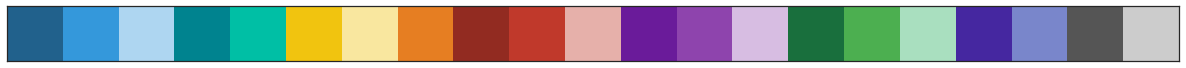

In [305]:

#format plots
sns.set(style='white', context='notebook', font_scale=1.5, 
        rc={'font.sans-serif': 'DejaVu Sans', 'lines.linewidth': 2.5})

#create a custom color palette
palette21 = ['#21618C', '#3498DB', '#AED6F1', '#00838F', '#00BFA5',
             '#F1C40F', '#F9E79F', '#E67E22', '#922B21', '#C0392B', 
             '#E6B0AA', '#6A1B9A', '#8E44AD', '#D7BDE2', '#196F3D', 
             '#4CAF50', '#A9DFBF', '#4527A0', '#7986CB', '#555555', 
             '#CCCCCC']
sns.palplot(palette21)

#create a color map
blog_blue = '#64C0C0'
blue_cmap = sns.light_palette(blog_blue, as_cmap=True)

In [306]:
#count the number of articles published each month
d = ads_df.groupby(['publication_year','publication_month'])['words'].count().reset_index(drop=True)

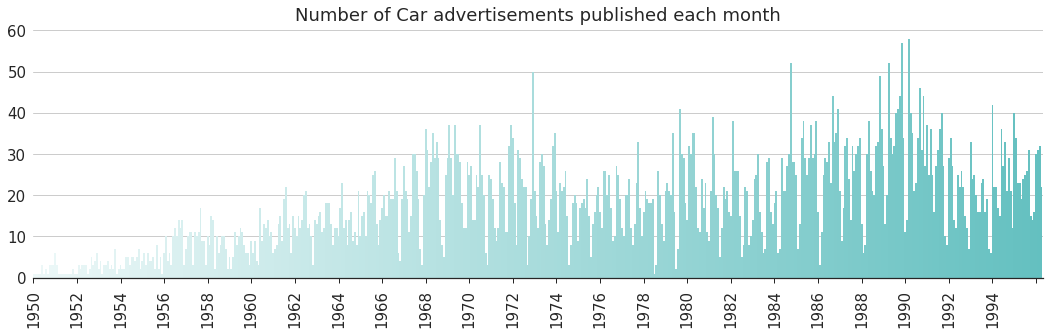

In [309]:
#plot the number of articles published each month
#initialize a figure
plt.figure(figsize=(15,5))
#plot bars
axes = plt.bar(d.index, d, width=1, color=blue_cmap(d.index.values/d.index.max()))  #color according to month

#format plot
plt.grid(axis='y')
plt.xlim(0,len(d))
plt.xticks(range(0,len(d),24), range(1950,1995,2), rotation=90)
plt.tick_params(axis='x', length=5)
plt.title('Number of Car advertisements published each month')
sns.despine(left=True)

plt.tight_layout()
plt.savefig('car_ads_per_month.png', dpi=300)

In [317]:
time_frame = ['publication_year', 'publication_month']
#create dataframe with word proportions
def word_proportions(df, word_list):
    all_r = pd.DataFrame(columns=word_list, index=d.index)
    for i, word in enumerate(word_list):
        all_r[word] = pd.concat([df.loc[:, time_frame],
                                df['words'].apply(lambda x: word in x)], axis=1) \
                               .groupby(by=time_frame).sum().reset_index(drop=True)
        if np.mod(i, 100)==0:
            print('total words', len(word_list), 'word', i, 'complete')
    return all_r

In [ ]:
all_r_avg_distinct = word_proportions(ads_df, avg_distinctive)
all_rchi_words = word_proportions(ads_df, chi_words)
all_r_tf_idf_words = word_proportions(ads_df, tf_idf_words)

In [320]:
all_r_avg_distinct.to_pickle('all_r_avg_distinct.pkl')
all_rchi_words.to_pickle('all_r_chi-words.pkl')
all_r_tf_idf_words.to_pickle('all_r_tf_idf_words.pkl')

In [322]:
def find_bursts(d, all_r, word_list):
    '''
    burst detection function
    '''
    s = 2  #resolution of state jumps; higher s --> fewer but stronger bursts
    gam = 0.5 #difficulty of moving up a state; larger gamma --> harder to move up states, less bursty
    n = len(d) #number of timepoints
    smooth_win = 5
    
    all_bursts = pd.DataFrame(columns=['begin', 'end', 'weight'])
    
    for i, word, in enumerate(word_list):
        r = all_r.loc[:, word].astype(int)
        
        #find the optimal state sequence (using the Viterbi algorithm)
        [q,d,r,p] = bd.burst_detection(r,d,n,s,gam,smooth_win)
        
        #enumerate the bursts
        bursts = bd.enumerate_bursts(q, word)
        
        #find weights of each burst
        bursts_weighted = bd.burst_weights(bursts, r, d, p)
        
        #add the weighted burst to list of all bursts
        all_bursts = all_bursts.append(bursts_weighted, ignore_index=True)
        
        #print a progress report every 100 words
        if np.mod(i,100)==0:
            print('total words', len(word_list), 'word',i,'complete')
    
    return all_bursts.sort_values(by='weight', ascending=False)
    

In [324]:
bursts_avg_distinctive = find_bursts(d, all_r_avg_distinct, avg_distinctive)

total words 6615 word 0 complete
total words 6615 word 100 complete
total words 6615 word 200 complete
total words 6615 word 300 complete
total words 6615 word 400 complete
total words 6615 word 500 complete
total words 6615 word 600 complete
total words 6615 word 700 complete
total words 6615 word 800 complete
total words 6615 word 900 complete
total words 6615 word 1000 complete
total words 6615 word 1100 complete
total words 6615 word 1200 complete
total words 6615 word 1300 complete
total words 6615 word 1400 complete
total words 6615 word 1500 complete
total words 6615 word 1600 complete
total words 6615 word 1700 complete
total words 6615 word 1800 complete
total words 6615 word 1900 complete
total words 6615 word 2000 complete
total words 6615 word 2100 complete
total words 6615 word 2200 complete
total words 6615 word 2300 complete
total words 6615 word 2400 complete
total words 6615 word 2500 complete
total words 6615 word 2600 complete
total words 6615 word 2700 complete
tota

In [359]:
bursts_avg = find_bursts(d, all_r_avg_distinct, avg_distinctive)
bursts_chi = find_bursts(d, all_rchi_words, chi_words)
bursts_tfidf = find_bursts(d, all_r_tf_idf_words, tf_idf_words)

total words 10896 word 0 complete
total words 10896 word 100 complete
total words 10896 word 200 complete
total words 10896 word 300 complete
total words 10896 word 400 complete
total words 10896 word 500 complete
total words 10896 word 600 complete
total words 10896 word 700 complete
total words 10896 word 800 complete
total words 10896 word 900 complete
total words 10896 word 1000 complete
total words 10896 word 1100 complete
total words 10896 word 1200 complete
total words 10896 word 1300 complete
total words 10896 word 1400 complete
total words 10896 word 1500 complete
total words 10896 word 1600 complete
total words 10896 word 1700 complete
total words 10896 word 1800 complete
total words 10896 word 1900 complete
total words 10896 word 2000 complete
total words 10896 word 2100 complete
total words 10896 word 2200 complete
total words 10896 word 2300 complete
total words 10896 word 2400 complete
total words 10896 word 2500 complete
total words 10896 word 2600 complete
total words 1

In [361]:
bursts_avg_distinctive.to_pickle('burst_avg.pkl')
bursts_chi.to_pickle('burst_chi.pkl')
bursts_tfidf.to_pickle('burst_tfidf.pkl')

# Visualize 

In [418]:
def visualize_bursts(n_bursts, bursts, r, title):
    top_bursts = bursts.sort_values(by='weight', ascending=False).reset_index(drop=True).loc[:n_bursts,:]
    #sort bursts by end date
    sorted_bursts = top_bursts.sort_values('end', ascending=False).reset_index(drop=True)
    #for burst that end at the last timepoint, sort by start
    last_timepoint = np.max(sorted_bursts['end'])
    sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:] = sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:].sort_values(by='begin', ascending=False).reset_index(drop=True)
    
    heatmap_data = r.loc[:,set(sorted_bursts['label'])]
    
    #find the baseline proportions sum(r)/sum(d) for each label
    baseline_p = heatmap_data.sum(axis=0) / d.sum()

    #convert r values into proportions at each timepoint
    heatmap_data = heatmap_data.apply(lambda x: x/d)

    #sort the rows according to the order used in the timeline
    order = sorted_bursts['label'].drop_duplicates(keep='last').values
    
    #transpose data and reindex the data according to the sorted word order
    heatmap_data = heatmap_data.T.reindex(order)

    #optional: demean proportions
    #heatmap_data = heatmap_data - heatmap_data.mean(axis=1)

    #optional: convert proportions into multiples of the baseline proportion
    heatmap_data = heatmap_data.apply(lambda x: x/baseline_p[x.index])

    #smooth proportions with the same smoothing window used in burst detection
    smoothed_heatmap_data = heatmap_data.rolling(window=5, center=True, axis=1).mean()

    #create the heatmap
    plt.figure(figsize=(10,30))
    ax = sns.heatmap(smoothed_heatmap_data[::-1], vmin=0, vmax=2.5, cmap=blue_cmap, yticklabels=True,
                 cbar_kws = dict(use_gridspec=False, location="bottom", pad=0.05, shrink=0.7))
    plt.title('Normalized proportions of "bursting" ' + title + ' words over time')
    plt.xticks(range(0,n,24), range(1945,1995,2), rotation='vertical')

    #create boxes around bursting periods
    for index, burst in sorted_bursts.iterrows():
        
        #define outline positions
        y = smoothed_heatmap_data.index.get_loc(burst['label'])
        y = len(smoothed_heatmap_data) - y - 1 #reverse since it counts from bottom
        xstart = burst['begin'] 
        width = burst['end'] - burst['begin'] + 1
    
        #draw rectangle
        ax.add_patch(plt.Rectangle((xstart,y), width, height=1, alpha=1, 
                           facecolor='none', edgecolor='k', linewidth=1))
    plt.savefig(title + "_heatmap.png", bbox_inches="tight", dpi=300)

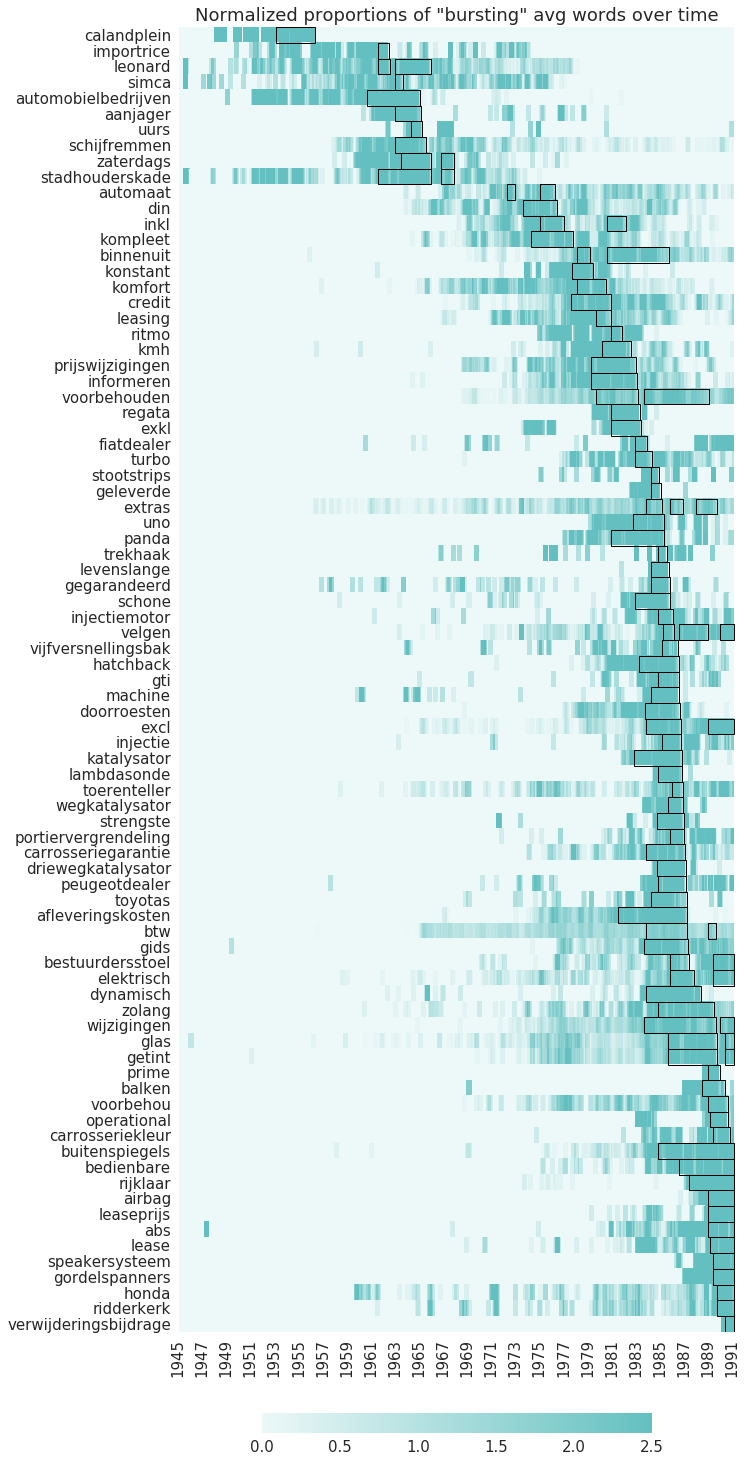

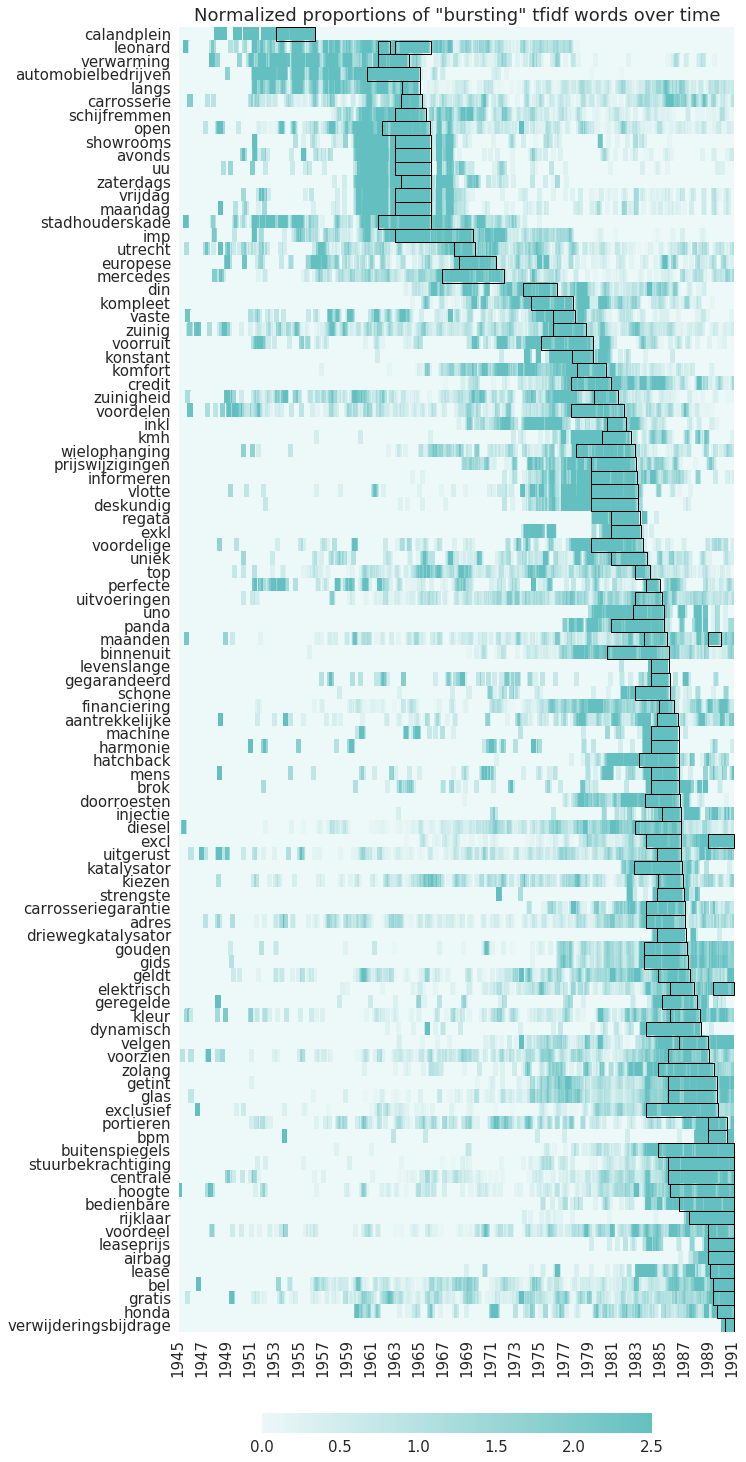

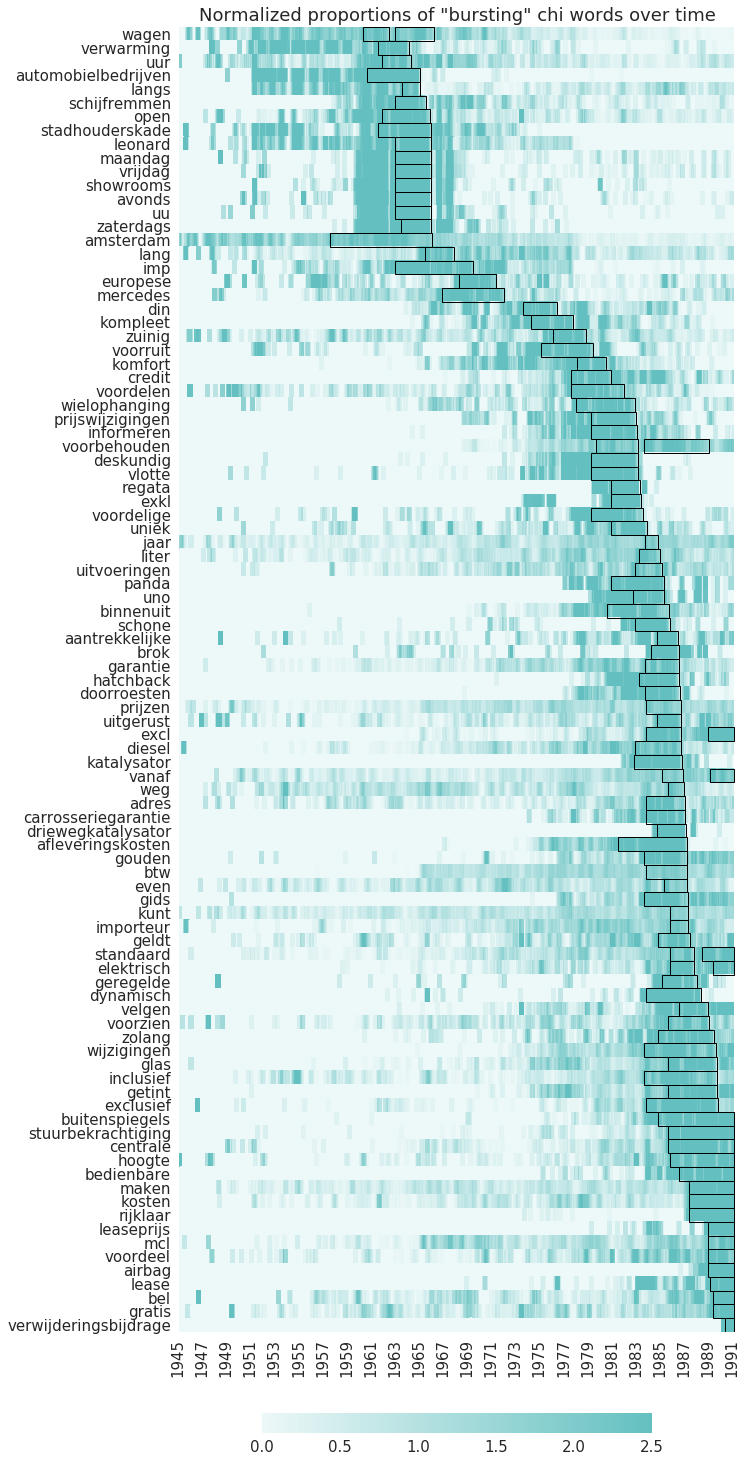

In [420]:
visualize_bursts(100, bursts_avg_distinctive, all_r_avg_distinct, 'avg')
visualize_bursts(100, bursts_tfidf, all_r_tf_idf_words, 'tfidf')
visualize_bursts(100, bursts_chi, all_rchi_words, 'chi')

In [376]:
corpus = np.to_array(df['ocr'])

AttributeError: module 'numpy' has no attribute 'to_array'

In [17]:
from nltk import word_tokenize
from gensim import corpora
from gensim import models
import pyLDAvis
import pyLDAvis.gensim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
ldainput_m1 = df["ocr"].apply(word_tokenize)

In [ ]:
id2word_m1 = corpora.Dictionary(ldainput_m1)


In [ ]:
ldacorpus_m1 = [id2word_m1.doc2bow(doc) for doc in ldainput_m1] 

In [ ]:
lda_m1 = models.LdaModel(ldacorpus_m1, id2word=id2word_m1, num_topics=20)
lda_m1.print_topics()

In [18]:
stoplist = stopwords.words('dutch')
docs = [' '.join(filter(None,filter(lambda word: word not in stoplist, line))) for line in df['ocr'].str.lower().str.split(' ')]

In [19]:
ldainput_m2 = [doc.split() for doc in docs]      

In [20]:
id2word_m2 = corpora.Dictionary(ldainput_m2)                       
ldacorpus_m2 = [id2word_m2.doc2bow(doc) for doc in ldainput_m2]  
#lda_m2 = models.LdaModel(ldacorpus_m2, id2word=id2word_m2, num_topics=10)
#lda_m2.print_topics(num_words=5)

2018-01-31 10:34:13,256 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-01-31 10:34:16,482 : INFO : adding document #10000 to Dictionary(355214 unique tokens: ['(reuter)', '(zwarte)', '1968', 'aangespannen', 'aantal']...)
2018-01-31 10:34:19,954 : INFO : adding document #20000 to Dictionary(606002 unique tokens: ['(reuter)', '(zwarte)', '1968', 'aangespannen', 'aantal']...)
2018-01-31 10:34:23,458 : INFO : adding document #30000 to Dictionary(809666 unique tokens: ['(reuter)', '(zwarte)', '1968', 'aangespannen', 'aantal']...)
2018-01-31 10:34:24,033 : INFO : built Dictionary(841704 unique tokens: ['(reuter)', '(zwarte)', '1968', 'aangespannen', 'aantal']...) from 31567 documents (total 7449403 corpus positions)


In [ ]:
ldacorpus_m3 = ldacorpus_m1       # reuse corpus from Model 1 
id2word_m3 = id2word_m1           # and thus, also use id2word-mapping
tfidfcorpus_m3 = models.TfidfModel(ldacorpus_m3)
lda_m3 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m3[ldacorpus_m3],id2word=id2word_m3,num_topics=10)
lda_m3.print_topics(num_words=5)

In [21]:
id2word_m4 = corpora.Dictionary(ldainput_m2)        # reuse input from M1     

id2word_m4.filter_extremes(no_below=10, no_above=0.85)   # do not consider all words that occur in less than n=5 documents
                                                    # or in more than 50% of all documents.

ldacorpus_m4 = [id2word_m4.doc2bow(doc) for doc in ldainput_m2]
tfidfcorpus_m4 = models.TfidfModel(ldacorpus_m4)
#lda_m4 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m4[ldacorpus_m4],id2word=id2word_m4,num_topics=50, )
lda_m4 = models.LdaModel(tfidfcorpus_m4[ldacorpus_m4], id2word=id2word_m4, num_topics=50,iterations=5, passes=1, alpha='auto', eval_every=5)


2018-01-31 10:34:32,461 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-01-31 10:34:35,640 : INFO : adding document #10000 to Dictionary(355214 unique tokens: ['(reuter)', '(zwarte)', '1968', 'aangespannen', 'aantal']...)
2018-01-31 10:34:38,969 : INFO : adding document #20000 to Dictionary(606002 unique tokens: ['(reuter)', '(zwarte)', '1968', 'aangespannen', 'aantal']...)
2018-01-31 10:34:42,346 : INFO : adding document #30000 to Dictionary(809666 unique tokens: ['(reuter)', '(zwarte)', '1968', 'aangespannen', 'aantal']...)
2018-01-31 10:34:42,893 : INFO : built Dictionary(841704 unique tokens: ['(reuter)', '(zwarte)', '1968', 'aangespannen', 'aantal']...) from 31567 documents (total 7449403 corpus positions)
2018-01-31 10:34:44,034 : INFO : discarding 784422 tokens: [('(zwarte)', 7), ('apartheidswet', 2), ('beroepszaken,', 1), ('contractarbeiders,', 2), ('mehlolo', 1), ('ontkracht,', 2), ('rikhoto', 1), ('stadsgebieden', 1), ('teruggeweest', 3), ('verblijf.', 6)]

2018-01-31 10:35:29,211 : INFO : topic #96 (0.012): 0.003*"vanavond" + 0.002*"corea" + 0.002*"•" + 0.002*"paus." + 0.002*"buitenlanders" + 0.002*"zwarte" + 0.002*"minister" + 0.002*"onbepaalde" + 0.002*"lang" + 0.002*"arnhem"
2018-01-31 10:35:29,213 : INFO : topic #53 (0.012): 0.004*"japanse" + 0.003*"oshima" + 0.003*"bowie" + 0.003*"(20.15):" + 0.003*"artsen" + 0.003*"mijnwerkers" + 0.003*"fusie" + 0.002*"uur):" + 0.002*"boek" + 0.002*"geschiedenis"
2018-01-31 10:35:29,215 : INFO : topic #87 (0.012): 0.003*"zün" + 0.003*"we" + 0.002*"mensen" + 0.002*"bü" + 0.002*"waddenzee" + 0.002*"woningen" + 0.002*"waar" + 0.002*"gemeente" + 0.002*"hü" + 0.002*"moeten"
2018-01-31 10:35:29,230 : INFO : topic diff=inf, rho=0.707107
2018-01-31 10:35:29,579 : INFO : PROGRESS: pass 0, at document #6000/31567
2018-01-31 10:35:32,945 : INFO : optimized alpha [0.012607473, 0.011041339, 0.011564243, 0.010755425, 0.010980682, 0.011438216, 0.011092048, 0.01116997, 0.012051093, 0.011942546, 0.011966853, 0.0116

2018-01-31 10:35:51,866 : INFO : topic #53 (0.021): 0.003*"amerikaanse" + 0.003*"we" + 0.002*"politieke" + 0.002*"zün" + 0.002*"japanse" + 0.002*"heel" + 0.002*"boek" + 0.002*"weet" + 0.002*"hü" + 0.002*"natuurlijk"
2018-01-31 10:35:51,869 : INFO : topic #96 (0.022): 0.002*"vanavond" + 0.002*"gaat" + 0.002*"muziek" + 0.002*"film" + 0.002*"minister" + 0.002*"nieuwe" + 0.002*"brinkman" + 0.002*"jaar" + 0.002*"orkest" + 0.002*"moeten"
2018-01-31 10:35:51,871 : INFO : topic #87 (0.024): 0.004*"zün" + 0.003*"we" + 0.003*"moeten" + 0.003*"mensen" + 0.003*"wel" + 0.003*"jaar" + 0.003*"bü" + 0.002*"nieuwe" + 0.002*"alleen" + 0.002*"waar"
2018-01-31 10:35:51,884 : INFO : topic diff=inf, rho=0.447214
2018-01-31 10:35:52,226 : INFO : PROGRESS: pass 0, at document #12000/31567
2018-01-31 10:35:55,339 : INFO : optimized alpha [0.017340913, 0.011848951, 0.013140584, 0.011137387, 0.011753254, 0.012810021, 0.011928055, 0.012209458, 0.014692658, 0.013940858, 0.014698184, 0.013044443, 0.012814567, 0.013

2018-01-31 10:36:04,965 : INFO : topic #96 (0.043): 0.002*"zyn" + 0.002*"the" + 0.002*"muziek" + 0.002*"uur" + 0.002*"eerste" + 0.002*"i" + 0.002*"jaar" + 0.002*"spelen" + 0.002*"gaat" + 0.002*"*"
2018-01-31 10:36:04,967 : INFO : topic #87 (0.051): 0.003*"zün" + 0.003*"we" + 0.003*"jaar" + 0.003*"moeten" + 0.003*"wel" + 0.003*"mensen" + 0.003*"volgens" + 0.002*"—" + 0.002*"bü" + 0.002*"nieuwe"
2018-01-31 10:36:04,981 : INFO : topic diff=inf, rho=0.353553
2018-01-31 10:36:05,301 : INFO : PROGRESS: pass 0, at document #18000/31567
2018-01-31 10:36:08,457 : INFO : optimized alpha [0.022637863, 0.012725766, 0.014481393, 0.011391718, 0.012455253, 0.013843962, 0.012558236, 0.012951531, 0.016975217, 0.015629806, 0.016983928, 0.014178307, 0.013857166, 0.015631657, 0.043348107, 0.012769196, 0.023467574, 0.024163689, 0.014449297, 0.012610218, 0.017330168, 0.015618421, 0.013283067, 0.019641582, 0.014675455, 0.014817226, 0.013844315, 0.014935355, 0.013446422, 0.014551821, 0.014465046, 0.012532553,

2018-01-31 10:36:26,638 : INFO : topic #96 (0.078): 0.002*"the" + 0.002*"film" + 0.002*"uur" + 0.002*"muziek" + 0.002*"mogelijkheden" + 0.002*"krant" + 0.002*"politie" + 0.002*"gaan." + 0.002*"kinderen" + 0.002*"*"
2018-01-31 10:36:26,640 : INFO : topic #87 (0.099): 0.003*"we" + 0.003*"volgens" + 0.003*"jaar" + 0.003*"wel" + 0.003*"moeten" + 0.003*"—" + 0.003*"zün" + 0.003*"mensen" + 0.002*"nieuwe" + 0.002*"minister"
2018-01-31 10:36:26,656 : INFO : topic diff=inf, rho=0.301511
2018-01-31 10:36:26,999 : INFO : PROGRESS: pass 0, at document #24000/31567
2018-01-31 10:36:30,424 : INFO : optimized alpha [0.028947735, 0.013354898, 0.015723459, 0.011682513, 0.013012075, 0.014709167, 0.013111559, 0.013666019, 0.019123318, 0.016982675, 0.019217201, 0.015095099, 0.014740432, 0.017406298, 0.071767405, 0.013340427, 0.030204544, 0.030820502, 0.015663095, 0.013244377, 0.019709012, 0.017456658, 0.014138031, 0.023496721, 0.015875725, 0.016054226, 0.014816154, 0.016380753, 0.014284349, 0.015702792, 0

2018-01-31 10:36:40,069 : INFO : topic #87 (0.182): 0.004*"zün" + 0.003*"jaar" + 0.003*"volgens" + 0.003*"we" + 0.003*"—" + 0.003*"wel" + 0.003*"moeten" + 0.003*"bü" + 0.003*"minister" + 0.003*"hü"
2018-01-31 10:36:40,085 : INFO : topic diff=inf, rho=0.267261
2018-01-31 10:36:48,824 : INFO : -23.847 per-word bound, 15084840.7 perplexity estimate based on a held-out corpus of 2000 documents with 17191 words
2018-01-31 10:36:48,825 : INFO : PROGRESS: pass 0, at document #30000/31567
2018-01-31 10:36:51,982 : INFO : optimized alpha [0.036096267, 0.014041209, 0.016954252, 0.011940578, 0.013621838, 0.015568414, 0.013617162, 0.014354555, 0.021200651, 0.018407015, 0.021253712, 0.015926573, 0.015515623, 0.019136908, 0.1088158, 0.013914154, 0.037173878, 0.038301647, 0.016745051, 0.013721871, 0.021907941, 0.019160766, 0.014902231, 0.027432876, 0.016973248, 0.017238405, 0.01574114, 0.017681709, 0.014891424, 0.016732736, 0.017073862, 0.013599239, 0.017101452, 0.026679674, 0.015987569, 0.017397197,

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

lda_m4_good = models.LdaModel(tfidfcorpus_m4[ldacorpus_m4], id2word=id2word_m4, num_topics=100,iterations=50, passes=5, alpha='auto', eval_every=5)
print(models.CoherenceModel(model=lda_m4_good, corpus=tfidfcorpus_m4[ldacorpus_m4], coherence='u_mass').get_coherence())

In [24]:
lda_m4.top_topics(tfidfcorpus_m4[ldacorpus_m4])

2018-01-31 10:41:24,756 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-31 10:41:24,950 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-31 10:41:25,133 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-31 10:41:25,324 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-31 10:41:25,504 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-31 10:41:25,695 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-31 10:41:25,888 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-31 10:41:26,111 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-31 10:41:26,321 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-31 10:41:26,509 : INFO : CorpusAccumulator accumulated stats from 10000 documents
2018-01-31 10:41:26,709 : INFO : CorpusAccumulator accumulated stats from 11000 documents
2018-01-31 10:41:26

[([(0.012907529, 'uur)'),
   (0.011882158, 'nieuws.'),
   (0.010345802, 'journaal'),
   (0.010269514, 'nos:'),
   (0.0069034654, "avro's"),
   (0.0068208384, 'journaal.'),
   (0.0067607784, 'serie.'),
   (0.0062178499, 'tros:'),
   (0.006172772, '2'),
   (0.0057404381, 'und'),
   (0.0053342576, '19.15'),
   (0.0052898275, 'avro:'),
   (0.0052189091, '20.00'),
   (0.0050952318, '19.00'),
   (0.0049795858, '17.30'),
   (0.0049494039, 'kro:'),
   (0.0048533301, '23.00'),
   (0.0048096026, 'slechthorenden'),
   (0.0047826734, 'brahms'),
   (0.0045697833, 'uitzending.')],
  -0.71766143103057156),
 ([(0.01433284, 'journaal.'),
   (0.012025078, 'nieuws.'),
   (0.010083159, 'nos:'),
   (0.0072500007, '18.00'),
   (0.006176969, 'hilversum'),
   (0.0061481879, 'radio'),
   (0.005710145, 'spanje'),
   (0.0055467682, '17.00'),
   (0.0054925261, 'magazine.'),
   (0.0054187691, 'informatief'),
   (0.0053603174, '20.15'),
   (0.0053549963, 'duitsland'),
   (0.0053225025, '19.00'),
   (0.0053052809, '

In [ ]:
vis_data = pyLDAvis.gensim.prepare(lda_m4,ldacorpus_m4,id2word_m4)
pyLDAvis.display(vis_data)

In [ ]:
cm1 = models.CoherenceModel(model=lda_m1, corpus=ldacorpus_m1, dictionary= id2word_m1, coherence='u_mass')  
naivecoh = cm1.get_coherence()
cm2 = models.CoherenceModel(model=lda_m2, corpus=ldacorpus_m2, dictionary= id2word_m2, coherence='u_mass')  
cleancoh = cm2.get_coherence()
#cm3 = models.CoherenceModel(model=lda_m3, corpus=ldacorpus_m3, coherence='u_mass')
cm3 = models.CoherenceModel(model=lda_m3, corpus=tfidfcorpus_m3[ldacorpus_m3], dictionary= id2word_m3, coherence='u_mass')
tfidfcoh = cm3.get_coherence()
cm4 = models.CoherenceModel(model=lda_m4, corpus=tfidfcorpus_m4[ldacorpus_m4], dictionary= id2word_m4, coherence='u_mass')
tfidffiltercoh = cm4.get_coherence()
print("Coherence of naive model = {}\nCoherence of clean model = {}\nCoherence of tf-idf model = {}\nCoherence of tf-idf model without extreme words {}".format(naivecoh, cleancoh, tfidfcoh,tfidffiltercoh))
print("NB: Note that it may not make too much sense to compare these vaues across different corpora")

In [ ]:
freq_dist(df['ocr'], 2500)

In [ ]:
cluster2['image_url'].loc[cluster2['ocr'].str.contains("amerika")]

In [ ]:
len(america)

SIZE!!

In [ ]:
df['mean_total_area'] = df['area'].groupby(pd.TimeGrouper('D')).aggregate(np.mean).dropna()
df['mean_total_area'].groupby(pd.TimeGrouper('12M')).aggregate(np.mean).dropna().plot()

The size of advertisements in NRC increases during the 90s 

In [ ]:
df['n_pages'].groupby(pd.TimeGrouper('12M')).aggregate(np.mean).dropna().plot()

The number of pages in NRC increases over time with a sharp increase from 1984 onwards. It stabilizes at the end of the 1980s.

In [ ]:
df['area-per-pages'] = df['mean_total_area'] / df['n_pages']
df['area-per-pages'].groupby(pd.TimeGrouper('M')).aggregate(np.mean).dropna().plot()

Similar pattern for every year. Dip in summer months (July/August) in size. In the 1980s the total area taken up by ads decreases but it rises again in the 1990s. 1970s and 1990s more advertisements. 

In [ ]:
#determine mean size of ads per day
size_mean = df['area'].groupby(pd.TimeGrouper('D')).aggregate(np.mean).dropna()
size_mean = size_mean.reset_index()
size_mean = size_mean.set_index(['date'])

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
test_stationarity(size_mean['area'])
size_mean['size_log'] = np.log(size_mean['area']) #calculate log
moving_avg = pd.rolling_mean(size_mean['size_log'],12)
size_mean_log_moving_avg_diff = size_mean['size_log'] - moving_avg
size_mean_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(size_mean_log_moving_avg_diff)

In [ ]:
#to do also plot dispersion of type of ads over time

Face recognition

In [ ]:
import cv2
import os